# Corn Disease Detection Based On Leaf Photos
Sebuah AI untuk mendeteksi penyakit pada tanaman jagung berdasarkan foto daunnya. AI ini menggunakan dataset dari kaggle pada link berikut : https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset

Sebelum digunakan dataset dibersihkan terlebih dahulu seperti menghapus beberapa gambar yang buram. Sehingga didapatlah dataset seperti berikut:
- Common Rust - 813 images
- Gray Leaf Spot - 409 images
- Blight -928 images
- Healthy - 1162 images

Pada tahap preparation data, kami melakukan tahapan sebagai berikut :
- Resize -> Mengatur ukuran gambar agar semua gambar mempunyai ukuran yang sama yaitu 224x224 px.
- Normalize -> Membagi ukuran pixel dengan 255 agar ukuran pixel berskala 0-1, ini akan memudahkan model machine learning untuk melakukan training nantinya.
- Augmentation -> Menambahkan ragam dan variasi foto.
- Splitting data -> Membagi data menjadi 80% untuk training, 10% untuk validation, dan 10% untuk testing

Model yang digunakan pada AI ini adalah CNN(Convolutional Neural Network) dengan arsitektur MobileNetV2, mengapa kami menggunakan model ini? Karena model ini adalah model yang mampu melakukan pengenalan dan pemrosesan gambar. Umumnya model ini digunakan untuk Object detection, image classification, face recognition, dsb yang berhubungan dengan gambar.



## Preparation


### Dataset Path
menetepakan path untuk menuju drive dimana dataset disimpan.

gray_leaf_spot dan augmented_gray_leaf_spot adalah path yang dibuat untuk melakukan data augmentasi khusus untuk class Gray Leaf Spot Saja.

In [13]:
data_path = 'balanced_corn_disease'
data_path_bfr_augmented = 'corn_disease'
# gray_leaf_spot = 'corn_disease/Gray_Leaf_Spot'
# split_data_path = 'split_corn_disease'
split_data_path = 'split_corn_disease_augmented'
train_data_path = 'split_corn_disease_augmented/train'
val_data_path = 'split_corn_disease_augmented/val'
test_data_path = 'split_corn_disease_augmented/test'
model_path = 'saved_model/model.h5'

### Import Libraries
Mengimport library yang dibutuhkan untuk kebutuhan preparation dan modelling data

In [29]:
import numpy as np
import os
import cv2
import shutil
import tensorflow as tf
import random
from PIL import Image
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import Counter
from tkinter import filedialog
from tkinter import Tk

## Preparation Data

### Function For count images per label
fungsi untuk menghitung jumlah gambar per label

In [4]:
# Debugging function to print counts per label
def debug_image_counts(label_array, stage):
    label_counts = Counter(label_array)
    print(f"\nImage counts {stage}:")
    for label, count in label_counts.items():
        print(f"  {label}: {count}")
    print(f"  Total images: {len(label_array)}\n")

### Load Images & Labels
Memuat gambar dan label dari dataset yang ada.

In [5]:
labels = []  # To store labels
images = []  # To store image arrays

for label in os.listdir(data_path):
    label_dir = os.path.join(data_path, label)
    for img_file in os.listdir(label_dir):
        img_path = os.path.join(label_dir, img_file)
        img = load_img(img_path, target_size=(224, 224))  # Resize images here
        img_array = img_to_array(img)  # Convert image to numpy array
        images.append(img_array)
        labels.append(label)  # Append label

images = np.array(images)  # Convert list to numpy array
labels = np.array(labels)  # Convert labels to numpy array

Menghitung jumlah gambar per label.

In [6]:
debug_image_counts(labels, stage="before augmentation")


Image counts before augmentation:
  Blight: 928
  Common_Rust: 813
  Gray_Leaf_Spot: 810
  Healthy: 1162
  Total images: 3713



### Augmentation for Gray Leaf Spot Label
Mengapa melakukan data augmentasi khusus untuk label gray leaf spot? karena data pada label gray leaf spot hanya berjumlah setengah dari label lainnya pada dataset. Hal ini akan meningkatkan prediksi dan akurasi pada class gray leaf spot nantinya.

Noted : Tahap ini hanya perlu dilakukan sekali, jika sudah dilakukan maka tidak perlu dilakukan lagi.

In [7]:
# # datagen parameters used for augmentation gray leaf spot label
# datagen = ImageDataGenerator(
#     rotation_range=30,
#     zoom_range=[0.8, 1],
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
#     vertical_flip=True,
#     fill_mode='reflect'
# )

In [8]:
# # Augment gray leaf spot images to balancing dataset
# for img_name in os.listdir(gray_leaf_spot):
#     img_path = os.path.join(gray_leaf_spot, img_name)

#     # Load and preprocess the image
#     img = load_img(img_path)  # Load image as PIL object
#     x = img_to_array(img)     # Convert to NumPy array
#     x = np.expand_dims(x, axis=0)  # Add batch dimension

#     # Generate augmented images
#     i = 0
#     for batch in datagen.flow(x, batch_size=1, save_to_dir=augmented_gray_leaf_spot, save_prefix='aug', save_format='jpg'):
#         i += 1
#         if i >= 1:  # Generate 1 augmented images per original image
#             break

### Normalize
Membagi nilai pixel dengan 255 agar nilai pixel berskala antara 0-1 sehingga memudahkan kerja model nantinya.

In [9]:
images = images / 255.0  # Scale pixel values to range [0, 1]

### Splitting Data
Membagi data yang ada menjadi 80% untuk training, 10% untuk validation, dan 10% untuk testing.

Noted : Tahap ini hanya perlu dilakukan sekali, jika sudah dilakukan maka tidak perlu dilakukan lagi karena hasil splitting data di simpan dalam direktori.

In [10]:
# # Subdirectories for train, val, and test
# train_dir = os.path.join(split_data_path, 'train')
# val_dir = os.path.join(split_data_path, 'val')
# test_dir = os.path.join(split_data_path, 'test')

# # Create output directories
# for dir_path in [train_dir, val_dir, test_dir]:
#     os.makedirs(dir_path, exist_ok=True)

# # Loop through each label folder
# for label in os.listdir(data_path):
#     label_path = os.path.join(data_path, label)

#     if not os.path.isdir(label_path):
#         continue  # Skip non-directory files

#     # Get all images for this label
#     images = os.listdir(label_path)
#     images = [os.path.join(label_path, img) for img in images]

#     # Split dataset
#     train_images, temp_images = train_test_split(images, test_size=0.2, random_state=42)
#     val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

#     # Create label subdirectories in train, val, and test
#     for split_dir, split_images in zip([train_dir, val_dir, test_dir], [train_images, val_images, test_images]):
#         label_split_dir = os.path.join(split_dir, label)
#         os.makedirs(label_split_dir, exist_ok=True)

#         # Move or copy images to their respective split folder
#         for img_path in split_images:
#             shutil.copy(img_path, label_split_dir)

# print("Dataset splitting complete!")

Cek jumlah gambar yang ada setelah dilakukan splitting

In [11]:
# Count images in each split and per label
for split in ['train', 'val', 'test']:
    split_dir = os.path.join(split_data_path, split)
    print(f"\n=== {split.capitalize()} Dataset ===")

    for label in os.listdir(split_dir):
        label_dir = os.path.join(split_dir, label)
        if os.path.isdir(label_dir):
            image_count = len(os.listdir(label_dir))
            print(f"Label '{label}': {image_count} images")



=== Train Dataset ===
Label 'Blight': 2741 images
Label 'Common_Rust': 2419 images
Label 'Gray_Leaf_Spot': 2339 images
Label 'Healthy': 3352 images

=== Val Dataset ===
Label 'Blight': 93 images
Label 'Common_Rust': 81 images
Label 'Gray_Leaf_Spot': 81 images
Label 'Healthy': 116 images

=== Test Dataset ===
Label 'Blight': 93 images
Label 'Common_Rust': 82 images
Label 'Gray_Leaf_Spot': 81 images
Label 'Healthy': 117 images


### Data Augmentation For Training Dataset
Menambahkan ragam dan variasi gambar dari semua class yang ada,hasil augmentasi disimpan kedalam direktori training sesuai dengan labelnya masing-masing.

Noted : Tahap ini hanya perlu dilakukan sekali, jika sudah dilakukan maka tidak perlu dilakukan lagi karena hasil augmentasi data di simpan dalam direktori.

In [19]:
# datagen = ImageDataGenerator(
#     rotation_range=30,
#     zoom_range=[0.5, 1],
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
#     vertical_flip=True,
#     fill_mode='reflect'
# )

# # Augment images for each label
# for label in os.listdir(train_data_path):
#     label_dir = os.path.join(train_data_path, label)

#     if not os.path.isdir(label_dir):
#         continue  # Skip non-directory files

#     print(f"Augmenting images for label: {label}")

#     for img_name in os.listdir(label_dir):
#         img_path = os.path.join(label_dir, img_name)

#         # Load and preprocess the image
#         img = load_img(img_path)  # Load as PIL object
#         x = img_to_array(img)     # Convert to NumPy array
#         x = np.expand_dims(x, axis=0)  # Add batch dimension

#         # Generate augmented images
#         i = 0
#         for batch in datagen.flow(x, batch_size=1, save_to_dir=label_dir, save_prefix='aug', save_format='jpg'):
#             i += 1
#             if i >= 3:  # Generate 3 augmented images per original image
#                 break

Cek jumlah gambar setelah dilakukan augmentasi pada training dataset

In [14]:
# Verify augmented training dataset
print("\n=== Training Dataset After Augmentation ===")
for label in os.listdir(train_data_path):
    label_dir = os.path.join(train_data_path, label)
    if os.path.isdir(label_dir):
        image_count = len(os.listdir(label_dir))
        print(f"Label '{label}': {image_count} images")



=== Training Dataset After Augmentation ===
Label 'Blight': 2741 images
Label 'Common_Rust': 2419 images
Label 'Gray_Leaf_Spot': 2339 images
Label 'Healthy': 3352 images


## Modelling
Model yang digunakan untuk project ini adalah CNN(Convolutional Neural Network) dengan arsitektur MobileNetV2

### Membuat Generator Untuk Proses Training Model

Menetapkan parameter untuk membuat generator

In [15]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
num_classes = 4

Melakukan rescalling, tidak perlu melakukan augmentasi lagi karena tahap augmentasi ditahap sebelumnya sudah di simpan di direktori

In [16]:
# Create ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

Membuat generator untuk masing-masing training, validation, dan testing

In [17]:
train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    seed=42
)

validation_generator = val_datagen.flow_from_directory(
    val_data_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    seed=42,
)

test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
)

Found 10851 images belonging to 4 classes.
Found 371 images belonging to 4 classes.
Found 373 images belonging to 4 classes.


### Build Model
Memuat arsitektur MobileNetV2

In [18]:
# Load MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling = 'avg')

# Freeze the base model layers
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


membuat early stopping untuk menghentikan proses training model jika sudah tidak terjadi peningkatan pada parameter val_loss hingga 5 epoch

In [19]:
# Define an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

membuat kustomisasi pada model dan mengkompile model

In [20]:
# Add custom classification head
x = base_model.output
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,652,740 (10.12 MB)

 Trainable params: 394,756 (1.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Train the Model
Latih model menggunakan 100 epochs

In [21]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,  # Adjust epochs as needed
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping],
    verbose=1
)

c:\Users\diima\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
339/339 ━━━━━━━━━━━━━━━━━━━━ 395s 1s/step - accuracy: 0.7401 - loss: 0.6574 - val_accuracy: 0.9091 - val_loss: 0.2471
Epoch 2/100
  1/339 ━━━━━━━━━━━━━━━━━━━━ 5:11 921ms/step - accuracy: 0.9688 - loss: 0.1968

c:\Users\diima\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9688 - loss: 0.1968 - val_accuracy: 0.9474 - val_loss: 0.1668
Epoch 3/100
339/339 ━━━━━━━━━━━━━━━━━━━━ 257s 757ms/step - accuracy: 0.8944 - loss: 0.2647 - val_accuracy: 0.9205 - val_loss: 0.1963
Epoch 4/100
339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8750 - loss: 0.1672 - val_accuracy: 0.8947 - val_loss: 0.2966
Epoch 5/100
339/339 ━━━━━━━━━━━━━━━━━━━━ 260s 768ms/step - accuracy: 0.9171 - loss: 0.2107 - val_accuracy: 0.9261 - val_loss: 0.1937
Epoch 6/100
339/339 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9375 - loss: 0.1786 - val_accuracy: 1.0000 - val_loss: 0.0704
Epoch 7/100
339/339 ━━━━━━━━━━━━━━━━━━━━ 263s 776ms/step - accuracy: 0.9295 - loss: 0.1742 - val_accuracy: 0.9318 - val_loss: 0.1801
Epoch 8/100
339/339 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9375 - loss: 0.1483 - val_accuracy: 0.8947 - val_loss: 0.2428
Epoch 9/100
339/339 ━━━━━━━━━━━━━━━━━━━━ 261s 768ms/step - accuracy: 0.9405 - loss: 0.1542 - val_

### Model Evaluation
Mengevaluasi performa model.

In [22]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f"Test accuracy: {test_acc:.4f}")


11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 957ms/step - accuracy: 0.9276 - loss: 0.2314
Test accuracy: 0.9347


### Visualize Model Evaluation
memvisualisasikan model evaluation menggunakan accuracy & loss, confusion matrix, dan classification report.

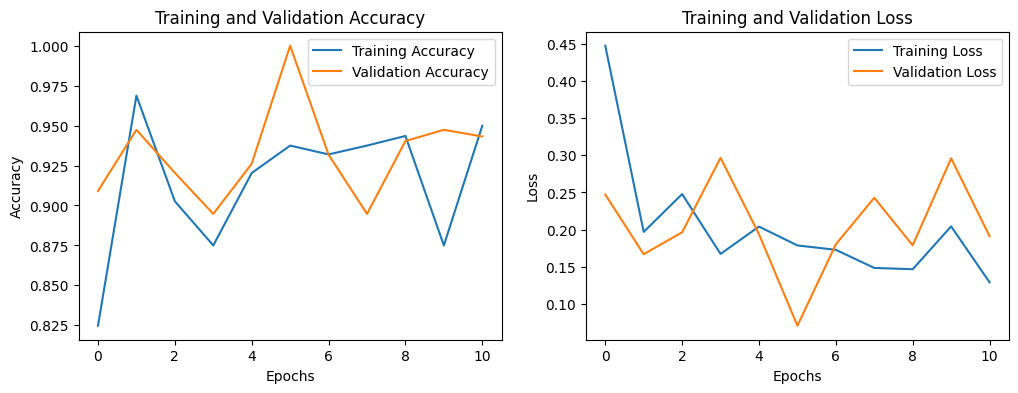

12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 940ms/step


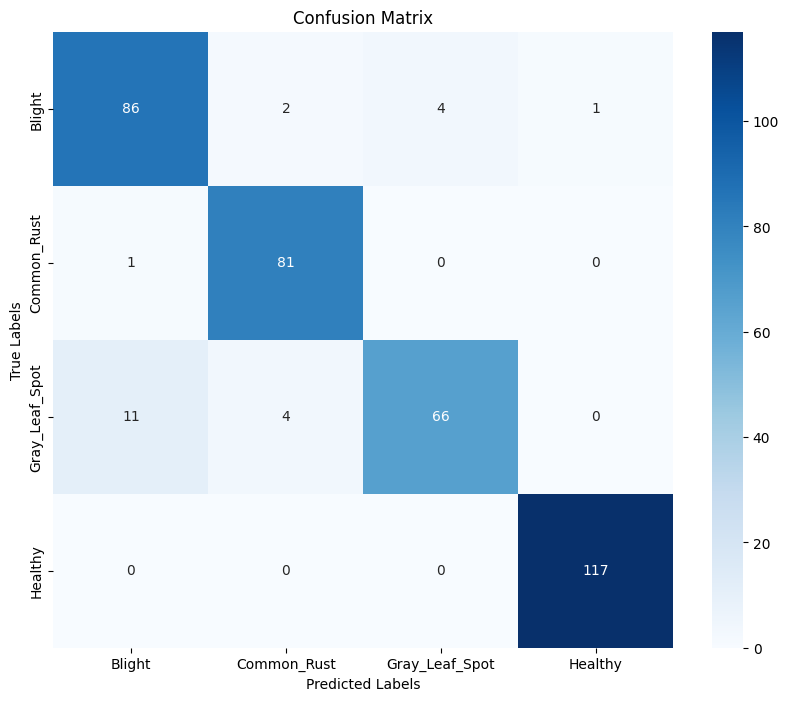

Classification Report:

                precision    recall  f1-score   support

        Blight       0.88      0.92      0.90        93
   Common_Rust       0.93      0.99      0.96        82
Gray_Leaf_Spot       0.94      0.81      0.87        81
       Healthy       0.99      1.00      1.00       117

      accuracy                           0.94       373
     macro avg       0.94      0.93      0.93       373
  weighted avg       0.94      0.94      0.94       373



In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# 1. Plot Training and Validation Accuracy/Loss
history_dict = history.history

# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Predictions and true labels
test_generator.reset()
predictions = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + 1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n")
print(report)

### Model Saving
Menyimpan model yang sudah selesai ditraining untuk digunakan saat testing menggunakan images.

In [ ]:
model.save('model.h5')

## Testing Model


Cek index masing-masing label

In [25]:
# Assuming you have a test_generator or train_generator
label_indices = train_generator.class_indices  # or test_generator.class_indices
print(label_indices)


{'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3}


Menampilkan 25 random images beserta label dan prediksinya

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step


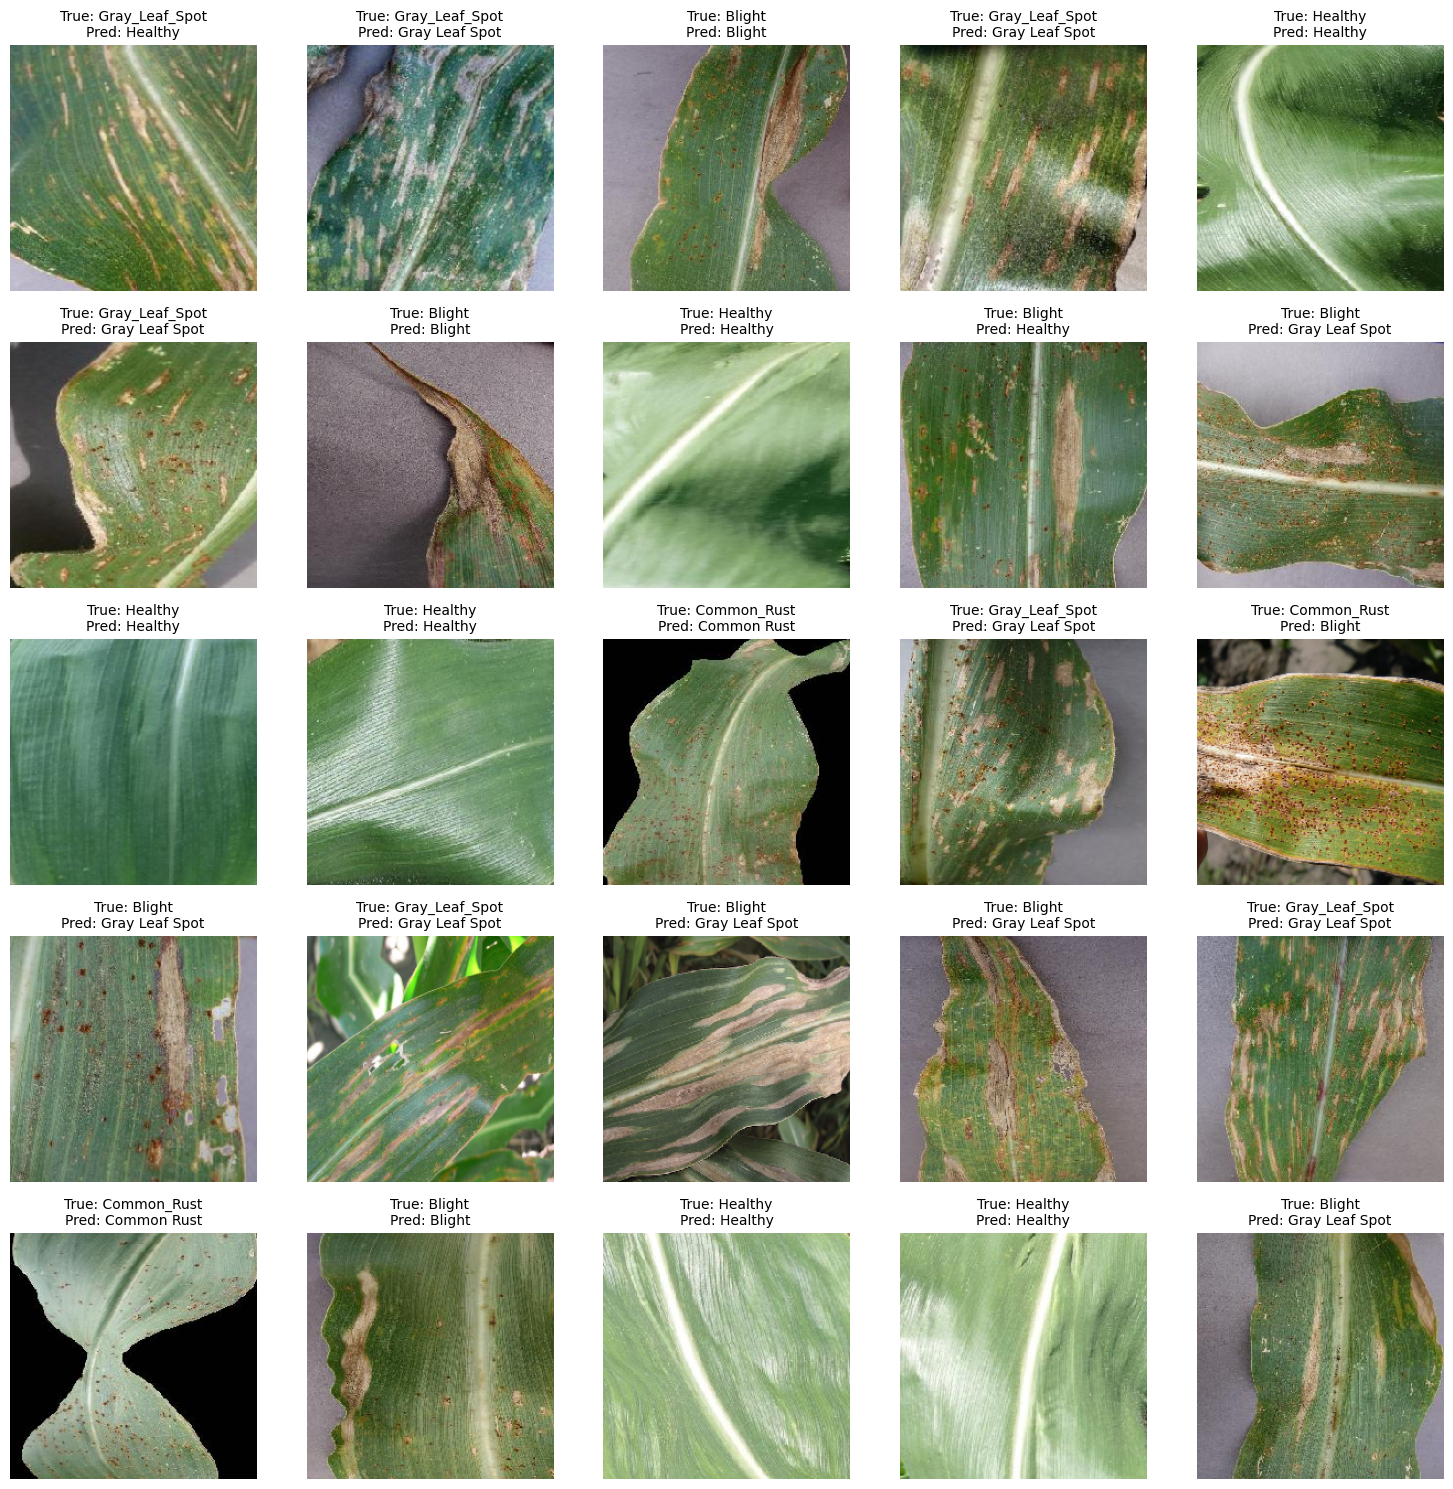

In [26]:
image_size = (224, 224)
model = load_model(model_path)

# Map label indices to label names (adjust to match your dataset)
label_map = {0: 'Blight', 1: 'Common Rust', 2: 'Gray Leaf Spot', 3: 'Healthy'}

# Helper function to load and preprocess an image
def preprocess_image(image_path):
    img = load_img(image_path, target_size=image_size)
    img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
    return img_array

# Get all test image paths
test_image_paths = []
test_labels = []
for class_name in os.listdir(test_data_path):
    class_path = os.path.join(test_data_path, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            test_image_paths.append(os.path.join(class_path, img_name))
            test_labels.append(class_name)  # Extract true labels from folder names

# Randomly sample 25 images
sample_indices = random.sample(range(len(test_image_paths)), 25)
sample_paths = [test_image_paths[i] for i in sample_indices]
sample_true_labels = [test_labels[i] for i in sample_indices]

# Preprocess images and predict
sample_images = np.array([preprocess_image(path) for path in sample_paths])
predictions = model.predict(sample_images)
predicted_labels = [label_map[np.argmax(pred)] for pred in predictions]

# Plot the images, true labels, and predictions
plt.figure(figsize=(15, 15))
for i, (img_path, true_label, predicted_label) in enumerate(zip(sample_paths, sample_true_labels, predicted_labels)):
    plt.subplot(5, 5, i + 1)
    img = load_img(img_path, target_size=image_size)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=10)
plt.tight_layout()
plt.show()